# Simulating random ZDC responses
### Script for generating ZDC responses for particles causing random responses

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
import pickle
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Mount Google Drive

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/My Drive/praca_mgr'
os.chdir(path)

Mounted at /content/drive


### Load data

In [ ]:
# load and plot the prepared datase
from numpy import load
from matplotlib import pyplot
import pickle

# load the dataset
data = load('./data/data_random_responses.npz')["arr_0"]#6.3835066348840055
data = np.float32(data)
print('Loaded: ',  data.shape, "max:", data.max())

data_cond = load('./data/conditional_data_random.npz')["arr_0"]
data_cond = pd.DataFrame(data_cond, columns =['Energy','Vx','Vy',	'Vz',	'Px',	'Py',	'Pz',	'mass',	'charge'])
COND_DIM=data_cond.shape[-1]
print('Loaded cond: ',  data_cond.shape)

Loaded:  (100308, 44, 44) max: 27.0
Loaded cond:  (100308, 9)


In [ ]:
# # load and plot the prepared datase
# from numpy import load
# from matplotlib import pyplot
# import pickle

# # load the dataset
# data = load('./data/data_random_responses.npz')["arr_0"][:10000]
# data = np.float32(data)
# print('Loaded: ',  data.shape, "max:", data.max())

# data_cond = load('./data/conditional_data_random.npz')["arr_0"][:10000]
# data_cond = pd.DataFrame(data_cond, columns =['Energy','Vx','Vy',	'Vz',	'Px',	'Py',	'Pz',	'mass',	'charge'])
# COND_DIM=data_cond.shape[-1]
# print('Loaded cond: ',  data_cond.shape)

In [ ]:
from utils import sum_channels_parallel_ as sum_channels_parallel
channels = data.copy().reshape(-1,44,44)
channels = pd.DataFrame(sum_channels_parallel(channels)).values

In [ ]:
x_train, x_test, y_train, y_test, ch_train, ch_test = train_test_split(data, data_cond, channels, test_size=0.2, shuffle=False)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, ch_train.shape, ch_test.shape)

(80246, 44, 44) (20062, 44, 44) (80246, 9) (20062, 9) (80246, 5) (20062, 5)


### Proof that there is no correlation between particel data and reponse image

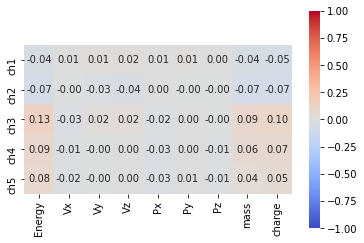

In [ ]:
import seaborn as sns
df_ch=pd.DataFrame(channels, columns = ["ch1","ch2","ch3","ch4","ch5"])
df = pd.concat([data_cond,df_ch],axis=1)
sns.heatmap(df.corr().iloc[9:,:9], vmax=1, vmin=-1, cmap="coolwarm", square=True, annot=True, fmt='.2f')

### Distribution of number of photons in orginal data

In [ ]:
channels = channels.sum(axis=-1).reshape(-1,1)

In [ ]:
_,counts = np.unique(channels, return_counts=True)
for n, count in enumerate(counts[:12]):
  print(f'{count/counts.sum()*100:.3f}',"% of examples (",count,") contain ", n+1,"photons", )

35.339 % of examples ( 35448 ) contain  1 photons
16.693 % of examples ( 16744 ) contain  2 photons
10.447 % of examples ( 10479 ) contain  3 photons
7.558 % of examples ( 7581 ) contain  4 photons
6.073 % of examples ( 6092 ) contain  5 photons
5.072 % of examples ( 5088 ) contain  6 photons
4.328 % of examples ( 4341 ) contain  7 photons
3.980 % of examples ( 3992 ) contain  8 photons
3.640 % of examples ( 3651 ) contain  9 photons
2.657 % of examples ( 2665 ) contain  10 photons
1.544 % of examples ( 1549 ) contain  11 photons
0.942 % of examples ( 945 ) contain  12 photons


### Define algorithm to generate random ZDC responses

In [ ]:
 def generate_random(): 
    # sample number of photons from the distribution of the data set  
    c = channels[np.random.randint(0,len(channels),1),0].astype(int)
    # sample location of first photon from uniform distribution
    center_x,center_y=np.random.randint(0,44,2)
    # sample locations of the remaining photon from N(0,3) distribution
    ids = np.random.normal(0,3,2*c).reshape(-1,2).astype(int)
    ids[:,0] = center_x + ids[:,0]
    ids[:,1] = center_y + ids[:,1]
    ids[0,:] = (center_y,center_x)
    # photons that would be placed outsite of the 44x44 response randomly increment number of photons on coordinates already containing a photon
    ids=ids[(ids[:,0]>=0) & (ids[:,0]<44)]
    ids=ids[(ids[:,1]>=0) & (ids[:,1]<44)]
    ids = ids[np.random.randint(len(ids),size=c),:]
    ids, counts = np.unique(ids,return_counts=True, axis=0)
    result=np.zeros((44,44))
    result[ids[:,0],ids[:,1]]=+counts
    return result

In [ ]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.5.0


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(ch_train).batch(batch_size=128)
dataset_cond = tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size=128)
dataset_with_cond = tf.data.Dataset.zip((dataset_cond,dataset)).shuffle(12800)

val_dataset = tf.data.Dataset.from_tensor_slices(ch_test).batch(batch_size=128)
val_dataset_cond = tf.data.Dataset.from_tensor_slices(y_test).batch(batch_size=128)
val_dataset_with_cond = tf.data.Dataset.zip((val_dataset_cond,val_dataset)).shuffle(12800)

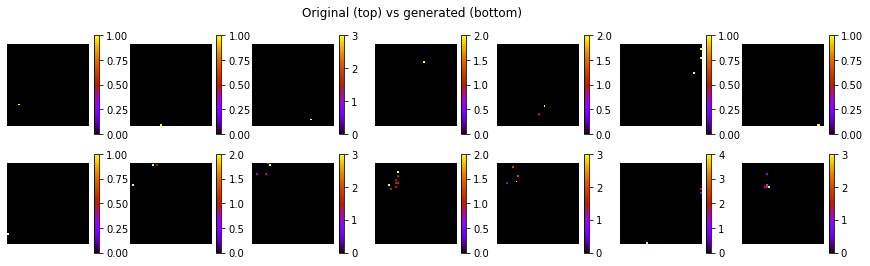

In [ ]:
def generate_and_save_images():
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).

  fig, axs = plt.subplots(2, 7, figsize=(15,4))
  for i in range(0,14):
    if i <7:
        x = x_test[10+7+i].reshape(44,44)
    else:
        x = generate_random().reshape(44,44)
    #x[x<=0]=x.max()*-0.1
    im = axs[i//7,i%7].imshow(x,interpolation='none', cmap='gnuplot')
    axs[i//7,i%7].axis('off')
    fig.colorbar(im, ax=axs[i//7,i%7])
  fig.suptitle("Original (top) vs generated (bottom)")
  plt.show()
generate_and_save_images()

### Calculate WS distances

In [ ]:
org=x_test.copy()
ch_org = np.array(org).reshape(-1,44,44)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values 
del org

from scipy.stats import wasserstein_distance
import pandas as pd
from utils import sum_channels_parallel_ as sum_channels_parallel
from sklearn.metrics import mean_absolute_error

def calculate_ws_ch(n_calc):
  ws= [0,0,0,0,0]
  for j in range(n_calc):
    results = [generate_random() for _ in x_test]
    try:
      ch_gen = np.array(results).reshape(-1,44,44)
      ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
      for i in range(5):
        ws[i] = ws[i] + wasserstein_distance(ch_org[:,i], ch_gen[:,i])
      ws =np.array(ws)
    except ValueError as e:
      print(e)
  ws = ws/n_calc
  print("ws mean",f'{ws.sum()/5:.2f}', end=" ")
  for n,score in enumerate(ws):
    print("ch"+str(n),f'{score:.2f}',end=" ")

calculate_ws_ch(5)

ws mean 0.11 ch0 0.13 ch1 0.08 ch2 0.10 ch3 0.14 ch4 0.09 